<a href="https://colab.research.google.com/github/sybenzvi/snxform-demo/blob/main/snxform_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Test Classification

Load PyTorch weights from a previous training session and run it on some EDR data.

**Note**: to make this run in Google Colab, we're using a PyTorch file produced on a CUDA GPU, converted to a CPU. For some reason, I find that this is producing *different* results than what I get when running with a GPU. This is not supposed to happen, so probably it points to a configuration error in the ViT class. I am tracking this down but if you see this message, the issue has not yet been fixed.

In [1]:
import torch
import json
import os

try:
    import snxform
except ImportError as e:
    print(e)
    !pip install git+https://github.com/desihub/desiutil.git@main
    !pip install git+https://github.com/desihub/desimodel.git@main
    !pip install git+https://github.com/desihub/desitarget.git@main
    !pip install git+https://github.com/desihub/desispec.git@main
    !pip install git+https://github.com/DESI-UR/snxform.git@main

import snxform
from snxform import io, preproc
from snxform.network import ViT

from urllib import request

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

No module named 'snxform'
  Cloning https://github.com/desihub/desiutil.git (to revision main) to /tmp/pip-req-build-qd5f8h6q
  Running command git clone --filter=blob:none --quiet https://github.com/desihub/desiutil.git /tmp/pip-req-build-qd5f8h6q
  Resolved https://github.com/desihub/desiutil.git to commit bdc44d99af4e4b6487c5042fd3ed5cdfdb5b8e5d
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 35.9 MB/s eta 0:00:00
  Created wheel for desiutil: filename=desiutil-3.4.3.dev1103-py3-none-any.whl size=1084529 sha256=9ae9a007da786fdf975a415193dfe253679e9dfdc78b34932d0a7edd8cd10ea7
  Stored in directory: /tmp/pip-ephem-wheel-cache-b5hd8agu/wheels/5f/1a/66/411c91cc0fb4749008cbcc8a76c3d4dffd36153484adede561
Successfully built desiutil
  Cloning https://github.com/desihub/desimodel.git (to revision main) to /tmp/pip-req-build-uw508mo1
  Running comm

## Initialize PyTorch Model

Load a `ViT` model from `snxform.network` using previously trained weights.

In [27]:
with open(os.path.join(snxform.src_path, 'etc/vit_model_V2_parameters.json'), 'r') as f:
    modelpars = json.load(f)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = ViT(
    cl=modelpars['cl'],
    n_patches=modelpars['patches'],
    n_blocks=modelpars['n_blocks'],
    hidden_d = modelpars['hidden_d'],
    n_heads = modelpars['n_heads'],
    out_d = 6).to(device)

ViT IS NOW IN cpu


In [28]:
model_state_dict = torch.load(os.path.join(snxform.src_path, 'etc/vit_model_V2_epoch26-cpu.pt'), map_location=device)
state = model.load_state_dict(model_state_dict)
print(f'{state}, model loaded')

<All keys matched successfully>, model loaded


## Read Spectra

Grab some spectra from the online EDR page, applying basic target selection to get (primarily) BGS galaxies.

These are just FITS files and you can read the HDUs directly, but it's convenient to use the `Spectra` class available in the `desispec` library to manage the data as a single encapsulated structure.

In [29]:
def get_exposure_data(tile: int, night: int, petal: int) -> str:
    """Access an EDR file using the TILE, NIGHT, and PETALs of the observation.
    """
    specfilename = f'spectra-{petal}-{tile}-thru{night}.fits'

    if not os.path.exists(specfilename):
        urlbase = 'https://data.desi.lbl.gov/public/edr/spectro/redux/fuji/tiles/cumulative'
        fileurl = os.path.join(urlbase, f'{tile}', f'{night}', specfilename)
        request.urlretrieve(fileurl, specfilename)

    return specfilename

In [32]:
# specfilename = get_exposure_data(96, 20210417, 4)
specfilename = get_exposure_data(81067, 20210327, 2)
cspectra = io.read_desi_spectra(specfilename)

INFO:spectra.py:391:read_spectra: iotime 1.481 sec to read spectra-2-81067-thru20210327.fits at 2024-05-21T20:34:17.659581


INFO:desiutil.log.dlm58.info:iotime 1.481 sec to read spectra-2-81067-thru20210327.fits at 2024-05-21T20:34:17.659581


In [33]:
#- Print the FIBERMAP table to show the targeting info.
cspectra.fibermap

TARGETID,COADD_FIBERSTATUS,TARGET_RA,TARGET_DEC,PMRA,PMDEC,REF_EPOCH,FA_TARGET,FA_TYPE,OBJTYPE,SUBPRIORITY,OBSCONDITIONS,RELEASE,BRICKNAME,BRICKID,BRICK_OBJID,MORPHTYPE,EBV,FLUX_G,FLUX_R,FLUX_Z,FLUX_W1,FLUX_W2,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,FLUX_IVAR_W1,FLUX_IVAR_W2,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,MASKBITS,SERSIC,SHAPE_R,SHAPE_E1,SHAPE_E2,REF_ID,REF_CAT,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_RP_MEAN_MAG,PARALLAX,PHOTSYS,PRIORITY_INIT,NUMOBS_INIT,SV2_DESI_TARGET,SV2_BGS_TARGET,SV2_MWS_TARGET,SV2_SCND_TARGET,DESI_TARGET,BGS_TARGET,MWS_TARGET,PLATE_RA,PLATE_DEC,COADD_NUMEXP,COADD_EXPTIME,COADD_NUMNIGHT,COADD_NUMTILE,MEAN_DELTA_X,RMS_DELTA_X,MEAN_DELTA_Y,RMS_DELTA_Y,MEAN_PSF_TO_FIBER_SPECFLUX,MEAN_FIBER_RA,STD_FIBER_RA,MEAN_FIBER_DEC,STD_FIBER_DEC,MIN_MJD,MAX_MJD,MEAN_MJD
int64,int32,float64,float64,float32,float32,float32,int64,uint8,bytes3,float64,int32,int16,bytes8,int32,int32,bytes4,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,int64,bytes2,float32,float32,float32,float32,bytes1,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,int16,float32,int16,int16,float32,float32,float32,float32,float32,float64,float32,float64,float32,float64,float64,float64
39633274808566851,0,176.8976569593588,51.86352083585595,0.0,0.0,2015.5,1152921504606846976,1,TGT,0.5297427209877034,516,9011,1769p517,590729,1091,EXP,0.02020127,12.668369,22.918108,35.34467,29.785856,24.56434,116.91167,33.502846,20.335537,2.879424,0.8137805,2.659209,4.810725,7.4191766,2.6594038,4.810868,7.41927,0,1.0,1.8609291,0.36212787,-0.17794251,0,,0.0,0.0,0.0,0.0,N,2100,1,1152921504606846976,514,0,0,0,0,0,176.8976569593588,51.86352083585595,3,3038.962,1,1,0.00066666666,0.0018257418,-0.003,0.0046547465,0.7461203,176.8976605896721,0.022880025,51.86353293695543,0.0517493,59301.30806148,59301.33480934,59301.32144191
39633282266041396,0,176.24176727158405,52.19847068095519,0.0,0.0,2015.5,1152921504606846976,1,TGT,0.6700116055873985,516,9011,1761p522,592507,3124,REX,0.021775655,4.1847496,17.151579,35.249813,46.21395,26.674234,392.8068,82.08371,44.58519,2.9722302,0.9411504,2.0381114,8.353386,17.167826,2.0413382,8.363522,17.184656,0,1.0,0.5406143,0.0,0.0,0,,0.0,0.0,0.0,0.0,N,2100,1,1152921504606846976,514,0,0,0,0,0,176.24176727158405,52.19847068095519,3,3038.962,1,1,-0.0056666667,0.006608076,0.002,0.0038297083,0.76818335,176.2417326981174,0.047781732,52.19846210301251,0.04580146,59301.30806148,59301.33480934,59301.32144191
39633282266041025,0,176.20813772969447,52.18181173521934,0.0,0.0,2015.5,1152921504606846976,1,TGT,0.273375942641759,516,9011,1761p522,592507,2753,SER,0.020857492,5.9138236,22.680677,44.405983,51.683052,31.14413,169.91525,37.008617,28.033817,2.550461,0.796507,2.3047185,8.839048,17.30577,2.3047357,8.839094,17.305859,0,6.0,0.87783283,0.006381807,-0.017205259,0,,0.0,0.0,0.0,0.0,N,2100,1,1152921504606846976,514,0,0,0,0,0,176.20813772969447,52.18181173521934,3,3038.962,1,1,-0.004,0.005715476,-0.00033333333,0.0031091264,0.7543969,176.20811303463836,0.056849107,52.181812661250085,0.043070726,59301.30806148,59301.33480934,59301.32144191
39633282266041661,0,176.26870742732802,52.155178638756865,0.0,0.0,2015.5,1152921504606846976,1,TGT,0.7898790896606152,519,9011,1761p522,592507,3389,REX,0.021017773,7.189374,13.717238,20.58886,20.81106,15.204686,207.23193,63.014862,42.580166,3.5492446,0.97412753,3.0349607,5.7906685,8.691492,3.0349667,5.790701,8.691545,0,1.0,0.6543141,0.0,0.0,0,,0.0,0.0,0.0,0.0,N,2000,1,1152921504606846976,257,0,0,0,0,0,176.26870742732802,52.155178638756865,3,3038.962,1,1,-0.0046666665,0.0060553006,-0.00033333333,0.0017320508,0.7639025,176.26867850713813,0.053118862,52.155179530484794,0.023806619,59301.30806148,59301.33480934,59301.32144191
39633274808568527,0,177.07071526283465,51.866092968503914,0.0,0.0,2015.5,1152921504606846976,1,TGT,0.76521928103

In [35]:
#- Display the exposure fibermap to show some telemetry for this measurement.
cspectra.exp_fibermap

TARGETID,PRIORITY,SUBPRIORITY,NIGHT,EXPID,MJD,TILEID,EXPTIME,PETAL_LOC,DEVICE_LOC,LOCATION,FIBER,FIBERSTATUS,FIBERASSIGN_X,FIBERASSIGN_Y,LAMBDA_REF,PLATE_RA,PLATE_DEC,NUM_ITER,FIBER_X,FIBER_Y,DELTA_X,DELTA_Y,FIBER_RA,FIBER_DEC,PSF_TO_FIBER_SPECFLUX,IN_COADD_B,IN_COADD_R,IN_COADD_Z
int64,int32,float64,int32,int32,float64,int32,float64,int16,int32,int64,int32,int32,float32,float32,float32,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,bool,bool,bool
39633274808566851,2100,0.5297427209877034,20210327,82496,59301.30806148,81067,1012.9829,2,182,2182,1000,0,228.01208,-100.53925,5400.0,176.8976569593588,51.86352083585595,2,228.004,-100.522,0.0,-0.005,176.89765591363513,51.86354096436507,0.7464810392271294,True,True,True
39633282266041396,2100,0.6700116055873985,20210327,82496,59301.30806148,81067,1012.9829,2,371,2371,1001,0,329.57535,-15.47034,5400.0,176.24176727158405,52.19847068095519,2,329.55,-15.457,-0.001,0.006,176.24176235983455,52.19844658993796,0.7690653971695086,True,True,True
39633282266041025,2100,0.273375942641759,20210327,82496,59301.30806148,81067,1012.9829,2,392,2392,1003,0,335.18314,-19.499792,5400.0,176.20813772969447,52.18181173521934,2,335.156,-19.483,0.001,0.004,176.20814475708042,52.181795861684044,0.7559994494376674,True,True,True
39633282266041661,2000,0.7898790896606152,20210327,82496,59301.30806148,81067,1012.9829,2,370,2370,1005,0,325.5868,-26.401794,5400.0,176.26870742732802,52.155178638756865,2,325.563,-26.382,-0.001,-0.001,176.2687010264886,52.15518254337044,0.7657570686358414,True,True,True
39633274808568527,2100,0.7652192810320754,20210327,82496,59301.30806148,81067,1012.9829,2,139,2139,1007,0,200.9732,-100.10681,5400.0,177.07071526283465,51.866092968503914,2,200.97,-100.097,-0.002,-0.001,177.0707021907451,51.86609694058763,0.7523914498787683,True,True,True
39633274812760405,2100,0.9298221696210949,20210327,82496,59301.30806148,81067,1012.9829,2,112,2112,1010,0,179.35152,-127.04923,5400.0,177.21507127021408,51.7579549605188,2,179.35,-127.041,-0.003,-0.0,177.21505189518751,51.75795490024756,0.7558099297296513,True,True,True
39633278541499105,2100,0.9336029925769358,20210327,82496,59301.30806148,81067,1012.9829,2,390,2390,1012,0,328.05804,-44.05937,5400.0,176.2575468260174,52.08444083271605,2,328.034,-44.04,-0.0,0.003,176.2575475413696,52.08442885228396,0.7351895935759761,True,True,True
39633278541499369,2000,0.7370996948688991,20210327,82496,59301.30806148,81067,1012.9829,2,369,2369,1013,0,323.14737,-40.85994,5400.0,176.28702496215308,52.0976223872622,2,323.126,-40.844,-0.002,0.005,176.2870137628739,52.09760222974375,0.7343250311366686,True,True,True
39633274812760206,2100,0.29787336236130546,20210327,82496,59301.30806148,81067,1012.9829,2,124,2124,1015,0,182.72586,-127.88742,5400.0,177.1934773420577,51.754529563493364,2,182.721,-127.875,0.0,-0.004,177.19347660933363,51.75454566817268,0.7515655256502001,True,True,True


In [19]:
#- Extract the data.
#  We've coadded the spectra across the b, r, and z cameras, so the
#  wavelength and flux tables are accessed via dictionary entries
#  keyed by 'brz'.
wave = cspectra.wave['brz']
flux = cspectra.flux['brz']
ivar = cspectra.ivar['brz']

fmap = cspectra.fibermap
expfmap = cspectra.exp_fibermap

### Preprocess the Spectra

Do a bit of cleanup for the ViT:
1. Remove skylines if they're still present after sky subtraction (not strictly necessary).
1. Downsample by a factor of 2.
1. Rescale the flux so it ranges from 0 to 1.

In [20]:
#- Clean sky lines and rebin.
newflux = preproc.remove_sky_lines(wave, flux, ivar)
newwave, newflux, newivar = preproc.rebin_flux(wave, newflux, ivar, nbins=3600)

#- Rescale the flux (not strictly necessary).
flux_rescaled = preproc.rescale_flux(newflux)

### Classify the Spectra

Apply the trained model to the data. The output is a classification vector

$$
\mathbf{y}^T = (y_1, y_2, y_3, \ldots, y_N),
$$

where each element is the probability that the object belongs to one of N classes, according to the network. The categories are:

1. Galaxy with no transient
2. SN Ia
3. (and higher): various CCSN models

In [36]:
def predict_data(model, flux, device):
    model.eval()

    if flux.ndim == 2:
        m, n = flux_rescaled.shape
        x = torch.Tensor(np.reshape(flux, (m, 1, n)))
    elif flux.ndim == 3:
        x = torch.Tensor(flux)
    else:
        raise ValueError('Flux needs to be of shape (m,1,n)')

    with torch.no_grad():
        x.to(device)
        output = model(x)

    return output

y_pred = predict_data(model, flux_rescaled, device)
y_val = y_pred.detach().cpu().numpy()

In [37]:
#- Extract the category predicted by the network.
i = np.argmax(y_val, axis=1)

#- Compute the max categorical probability for each prediction.
y_max = np.max(y_val, axis=1)

#- Select non-galaxy predictions where the network is confident.
select = (i > 1) & (y_max > 0.99)

In [38]:
matched_targets = cspectra.fibermap['TARGETID'][select]
for matched_target in matched_targets:
    print(f'TARGETID: {matched_target}: https://www.legacysurvey.org/viewer/desi-spectrum/edr/targetid{matched_target}')

TARGETID: 39633271042083138: https://www.legacysurvey.org/viewer/desi-spectrum/edr/targetid39633271042083138
TARGETID: 39633274795985889: https://www.legacysurvey.org/viewer/desi-spectrum/edr/targetid39633274795985889
TARGETID: 39633271037889487: https://www.legacysurvey.org/viewer/desi-spectrum/edr/targetid39633271037889487


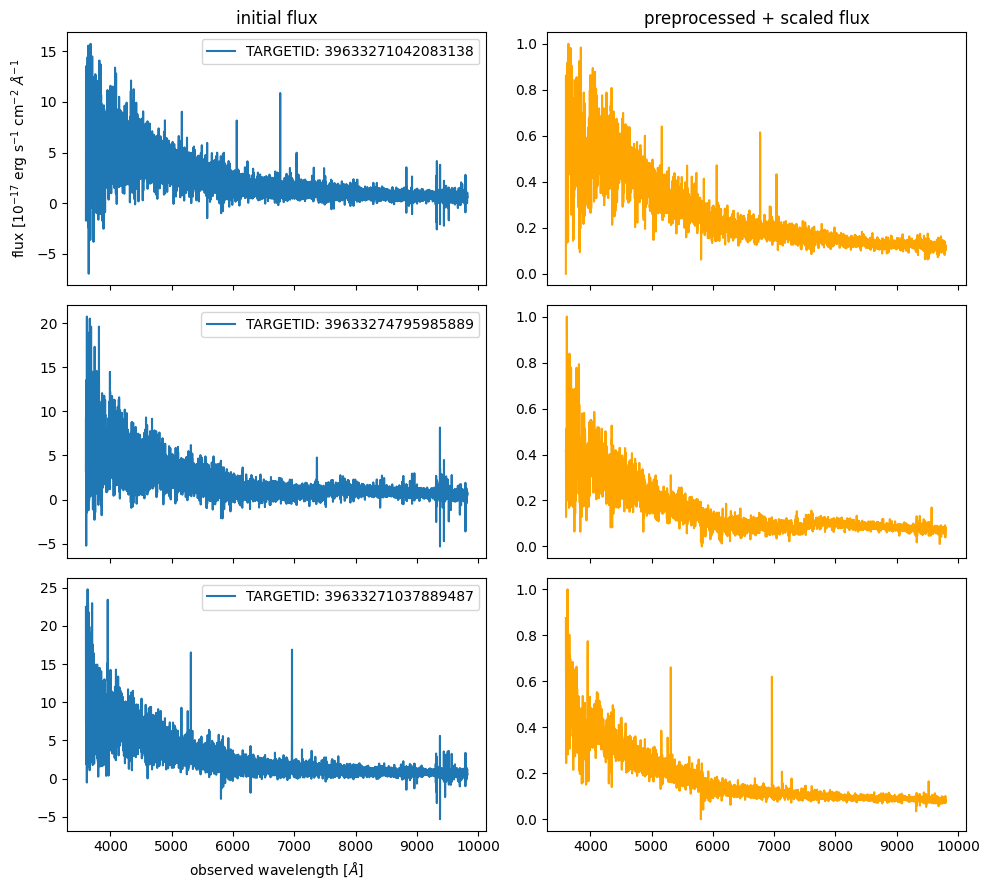

In [46]:
N = np.sum(select)
idx_sne = np.argwhere(select).flatten()

fig, axes = plt.subplots(N, 2, figsize=(10, 3*N), sharex=True, tight_layout=True)
for j, i_sn in enumerate(idx_sne):

    if N > 1:
        ax = axes[j][0]
        if j == 0:
            ax.set(ylabel=r'flux [$10^{-17}$ erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$',
                   title='initial flux')
            axes[j][1].set(title='preprocessed + scaled flux')
        elif j == N-1:
            ax.set(xlabel=r'observed wavelength [$\AA$]')
    else:
        ax = axes
        ax.set(xlabel=r'observed wavelength [$\AA$]',
               ylabel=r'flux [$10^{-17}$ erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$')

    ax.plot(wave, flux[i_sn], label=f'TARGETID: {fmap["TARGETID"][i_sn]}')
    ax.legend(loc='best')

    ax = axes[j][1]
    ax.plot(newwave, flux_rescaled[i_sn], color='orange')